In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.special import erf
from xraydb import xray_line, xray_edge, material_mu
from larch.xafs.pre_edge import preedge

mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'

[root] WARNING : Larchs apps and shell are not supported due to missing dependencies: cannot import name 'LarchWxApp' from 'larch.wxlib' (/srv/conda/envs/notebook/lib/python3.8/site-packages/larch/wxlib/__init__.py)


Correct over-absorption (self-absorption) for fluorescene XAFS
using the [FLUO alogrithm of D. Haskel](https://www3.aps.anl.gov/haskel/FLUO/Fluo-manual.pdf).
This is adapted the function from the function

from larch.xafs.fluo import fluo_corr

in the [xraylarch](https://xraypy.github.io/xraylarch/) package

# Make fake data

Text(0, 0.5, 'Uncorrected fluoresence')

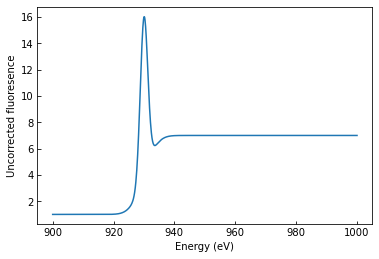

In [2]:
energy = np.linspace(900, 1000, 1000) # in eV
mu = 12*np.exp(-(energy - 930)**2/3) + 3*erf((energy - 930)/5) + 4

fig, ax = plt.subplots()

ax.plot(energy, mu)
ax.set_xlabel('Energy (eV)')
ax.set_ylabel('Uncorrected fluoresence')

# Define parameters

In [3]:
formula = 'Cu2OSeO3' # string for sample stoichiometry
elem = 'Cu' # atomic symbol or Z of absorbing element
edge = 'L3' # name of edge ('K', 'L3', ...) 
anginp = 45 # incident angle in degrees w.r.t sample surface
angout = 45 # outgoing angle in degrees w.r.t sample surface
line = 'L' # emission line measured

In [4]:
pre_opts = {'e0': None, 'nnorm': 1, 'nvict': 0,
            'pre1': None, 'pre2': -30,
            'norm1': 100, 'norm2': None,
            'step': None, 'nvict': 0}

# generate normalized mu for correction
preinp   = preedge(energy, mu, **pre_opts)

ang_corr = (np.sin(max(1.e-7, np.deg2rad(anginp))) /
            np.sin(max(1.e-7, np.deg2rad(angout))))

# find edge energies and fluorescence line energy
e_edge  = xray_edge(elem, edge).energy
e_fluor = xray_line(elem, line).energy

# calculate mu(E) for fluorescence energy, above, below edge

muvals = material_mu(formula, np.array([e_fluor, e_edge-10.0,
                                        e_edge+10.0]), density=1)

alpha   = (muvals[0]*ang_corr + muvals[1])/(muvals[2] - muvals[1])
mu_corr = mu*alpha/(alpha + 1 - preinp['norm'])

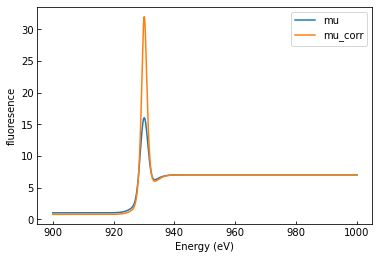

In [5]:
fig, ax = plt.subplots()

ax.plot(energy, mu, label='mu')
ax.plot(energy, mu_corr, label='mu_corr')

ax.set_xlabel('Energy (eV)')
ax.set_ylabel('fluoresence')
ax.legend()

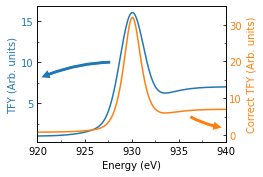

In [6]:
fig, axl = plt.subplots(figsize=(3+3/8, 2.5))

axl.plot(energy, mu, label='mu')
axl.set_ylabel('TFY (Arb. units)', color='C0')


axr = axl.twinx()
axr.plot(energy, mu_corr, color='C1')
axr.set_ylabel('Correct TFY (Arb. units)', color='C1')

axl.set_xlim(left=920, right=940)
axr.set_ylim(bottom=-2, top=35)


        
axl.set_xlabel('Energy (eV)')

#fig.subplots_adjust(right=0.8, bottom=0.18)
axl.xaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
axl.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))
axr.yaxis.set_major_locator(mpl.ticker.MultipleLocator(10))

axl.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
axl.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
axr.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))

arrow_l = mpl.patches.FancyArrowPatch(
        (928, 10),
        (920.1, 8),
        connectionstyle='arc3, rad=0.1',
        mutation_scale=20, 
    facecolor='C0',
    edgecolor='w', 
    )

arrow_r = mpl.patches.FancyArrowPatch(
        (936, 3.5),
        (939.9, 2),
        connectionstyle='arc3, rad=0.1',
        mutation_scale=20, 
    facecolor='C1',
    edgecolor='w', 
    )

[axl.add_patch(arr) for arr in [arrow_l, arrow_r]]

for ax, color in zip([axl, axr], ['C0', 'C1']):
    for t in ax.get_yticklabels():
        t.set_color(color)